# Место для выкладывания и проверки оптимизированных весов

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
from collections.abc import Iterable


In [2]:
# Подгриузить dataset. У меня он лежит в /data/ а у вас - не знаю.
def LoadDataset(path:str):
    files:list[list[str]] = list()
    labels:list[list[str]] = list()
    for i, (folder, children_folder, children_files) in enumerate(os.walk(path)):
        children_files = [f for f in children_files if f.endswith('.jpg')]
        if len(children_files) > 0:
            children_files = [os.path.join(folder,file) for file in children_files]
            basename = os.path.basename(folder)
            if basename in labels:
                index = labels.index(basename)
                files[index] += children_files
            else:
                labels.append(basename)
                files.append(children_files)
    labels = np.array(labels)
    for i,f_list in enumerate(files):
        files[i] = np.array(f_list)
    return [(f,i) for i,(c,l) in enumerate(zip(files,labels)) for f in c]
class CustomDataset:
    # Не стоит копировать к себе потому что он отвратительно медленный.
    def __init__(self, datasource:list[tuple[str,int]]):
        self.datasource = datasource
        self.transform = torchvision.models.MobileNet_V3_Large_Weights.IMAGENET1K_V2.transforms(antialias=True, interpolation = torchvision.transforms.InterpolationMode.BICUBIC)
    def __len__(self):
        return len(self.datasource)
    def __getitem__(self, index):
        image = Image.open(self.datasource[index][0])
        image.load()
        if self.transform is not None:
            image = self.transform(image)
        return image,self.datasource[index][1]
val_datasource = LoadDataset('/data/ImageNet-1k-valid')
train_datasource = LoadDataset('/data/ImageNet-1k')
val_dataset = CustomDataset(val_datasource)
train_dataset = CustomDataset(train_datasource)
val_dataloader = DataLoader(val_dataset, 256, shuffle=False, drop_last=False)
train_dataloader = DataLoader(val_dataset, 256, shuffle=True, drop_last=False)


In [3]:
import time
def time_to_str(value:float):
    t = []
    value = round(value)
    if value > 0: t.append(value%60); value = value//60
    if value > 0: t.append(value%60); value = value//60
    if value > 0: t.append(value%24); value = value//24
    if value > 0: t.append(value);
    t = [f'{v:02}{e}' for v,e in zip(t,['s','m','h','d'])]
    return ':'.join(t[-2:][::-1])
class stopwatch:
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self):
        return time.time() - self.start_time
    def progress(self, current, total):
        elapsed = self.elapsed()
        return f'{time_to_str(elapsed)}/{time_to_str(elapsed*total/current)}'
    def __repr__(self):
        return time_to_str(self.elapsed())
def collect_loss_and_accuracy(model:nn.Module, dataloader:Iterable[tuple[torch.Tensor,torch.Tensor]],
                              device=torch.device('cuda'), log:int = None, log_prefix:str='collect_loss_and_accuracy'):
    model.eval().cuda()
    criterion = torch.nn.CrossEntropyLoss(reduction = 'sum')
    accumulated_loss, accumulated_accuracy, samples_count = 0,0,0
    with torch.no_grad():
        timer = stopwatch()
        for i,(X,Y) in enumerate(dataloader):
            X,Y = X.to(torch.float32).to(device),Y.to(device)
            logits = model(X)
            loss:torch.Tensor = criterion(logits, Y)
            accumulated_loss += loss.detach()
            accumulated_accuracy += (logits.argmax(dim=1) == Y).sum()
            samples_count += X.size(0)
            if (log is not None) and (i%log == 0):
                print(f'{log_prefix}: {timer.progress(i+1, len(dataloader))}, acc:{accumulated_accuracy/samples_count}')
    return accumulated_loss/samples_count, accumulated_accuracy/samples_count
def parameters_count(module:torch.nn.Module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)
def zeros(model:nn.Module):
    return sum([(p==0).sum() for p in model.parameters()]).cpu().item()


In [11]:
initial_model = torchvision.models.mobilenet_v3_large(weights=torchvision.models.MobileNet_V3_Large_Weights.IMAGENET1K_V2).eval().cuda()
initial_loss, initial_accuracy = collect_loss_and_accuracy(initial_model, val_dataloader, log=64)
initial_model.cpu()
initial_accuracy, initial_loss


(tensor(0.7460, device='cuda:0'), tensor(1.2066, device='cuda:0'))

Я фиг знает почему точность 74.60%, а не 75.274% как указанно в таблице, ну да и не важно, нам же интересно сравнение, а не абсолютные величины.

**Внимание!!!** loss в пределах сотых долей зависит от размеров батча, там ошибкуи округления уже играют роль.

## Прореженный на 1M весов мобайлнет

In [5]:
model_sparsed1M = torchvision.models.mobilenet_v3_large().cpu().eval()
model_sparsed1M.load_state_dict(torch.load('sparsed/IMAGENET1K_V2_sparsed1M.pkl'))
print(f'IMAGENET1K_V2_sparsed1M.pkl sparsed weights:{zeros(model_sparsed1M)}({zeros(model_sparsed1M)/parameters_count(model_sparsed1M):.1%})')
sparsed1M_loss, sparsed1M_accuracy = collect_loss_and_accuracy(model_sparsed1M, val_dataloader, log=64)
model_sparsed1M.cpu()
print(f'acc:{sparsed1M_accuracy.item():.3%}, loss:{sparsed1M_loss.item():.4f}, Δ acc:{(sparsed1M_accuracy-initial_accuracy).item():+.3%}, Δ loss:{(sparsed1M_loss-initial_loss).item():+.4f}')


IMAGENET1K_V2_sparsed1M.pkl sparsed weights:1030465(18.8%)
collect_loss_and_accuracy: 02s/07m:04s, acc:0.8359375
collect_loss_and_accuracy: 02m:14s/06m:44s, acc:0.8068509697914124
collect_loss_and_accuracy: 04m:32s/06m:53s, acc:0.7666848301887512
collect_loss_and_accuracy: 06m:45s/06m:51s, acc:0.7495749592781067
acc:75.062%, loss:1.0118, Δ acc:+0.466%, Δ loss:-0.1948


In [6]:
# Проверить, что никакие веса не дообучались, все они либо оригинальные либо нулевые.
sum([((p!=0)&(p!=ip)).sum() for p,ip in zip(model_sparsed1M.parameters(), initial_model.parameters())]).cpu().item()


0

Напоминалка для себя, Порядок обучения: Сначала 50 эпох прореживания на 0.01 весов больше 3e-7 с адаптивным критерием 10-5, тоесть по сути 5. Как раз где-то тут наблюдается максимум роста accuracy, Потом ещё 5 циклов прореживания на 2e-3 с критерием 30 с одновременной разморозкой на 1e-3 весов меньших чем 1e-5 с таким же критерием. Далеко от оптимального, можно на много лучше, может потом выложу другой вариант.

P.S. Скачёк train loss на последних пяти шагах связан с тем, что случайно поставил дообучаться на полном имеджнете, не почищеннном от ошибок разметки.

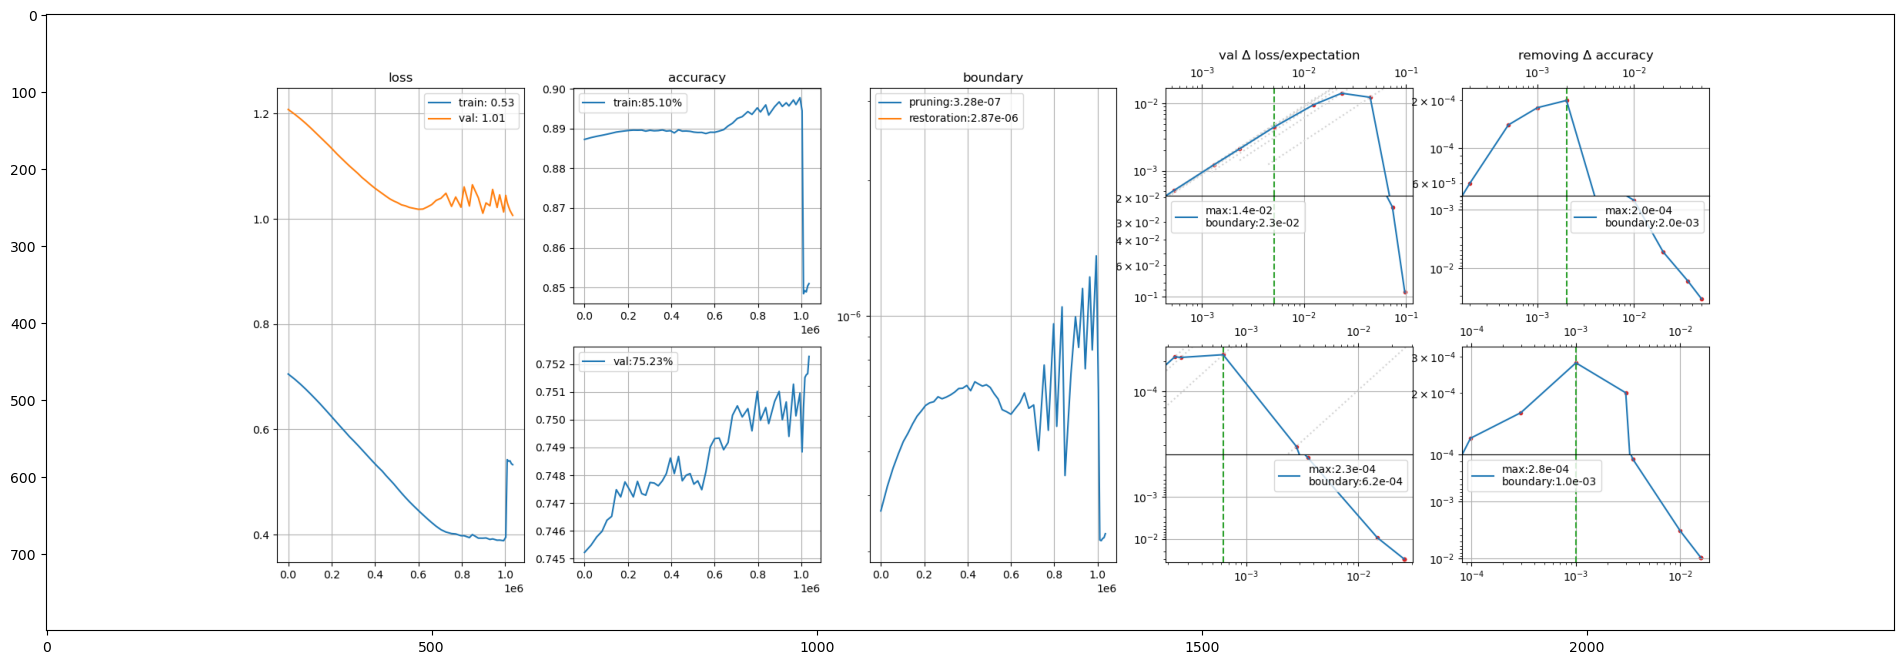

In [7]:
image = Image.open('sparsed/progress_step055.png')
image.load()
plt.figure(figsize=(24,8))
plt.imshow(image)
plt.show()

## Прореженный на 2.75M весов мобайлнет

In [8]:
model_sparsed2_75M = torchvision.models.mobilenet_v3_large().cpu().eval()
model_sparsed2_75M.load_state_dict(torch.load('sparsed/IMAGENET1K_V2_sparsed2_75M.pkl'))
print(f'IMAGENET1K_V2_sparsed1M.pkl sparsed weights:{zeros(model_sparsed2_75M)}({zeros(model_sparsed2_75M)/parameters_count(model_sparsed2_75M):.1%})')
sparsed2_75M_loss, sparsed2_75M_accuracy = collect_loss_and_accuracy(model_sparsed2_75M, val_dataloader, log=64)
model_sparsed2_75M.cpu()
print(f'acc:{sparsed2_75M_accuracy.item():.3%}, loss:{sparsed2_75M_loss.item():.4f}, Δ acc:{(sparsed2_75M_accuracy-initial_accuracy).item():+.3%}, Δ loss:{(sparsed2_75M_loss-initial_loss).item():+.4f}')


IMAGENET1K_V2_sparsed1M.pkl sparsed weights:2758995(50.3%)
collect_loss_and_accuracy: 02s/07m:20s, acc:0.8359375
collect_loss_and_accuracy: 02m:20s/07m:01s, acc:0.7895432710647583
collect_loss_and_accuracy: 04m:36s/06m:59s, acc:0.7493943572044373
collect_loss_and_accuracy: 06m:48s/06m:54s, acc:0.7300841808319092
acc:73.124%, loss:1.1090, Δ acc:-1.472%, Δ loss:-0.0976


In [9]:
# Проверить, что никакие веса не дообучались, все они либо оригинальные либо нулевые.
sum([((p!=0)&(p!=ip)).sum() for p,ip in zip(model_sparsed2_75M.parameters(), initial_model.parameters())]).cpu().item()


0

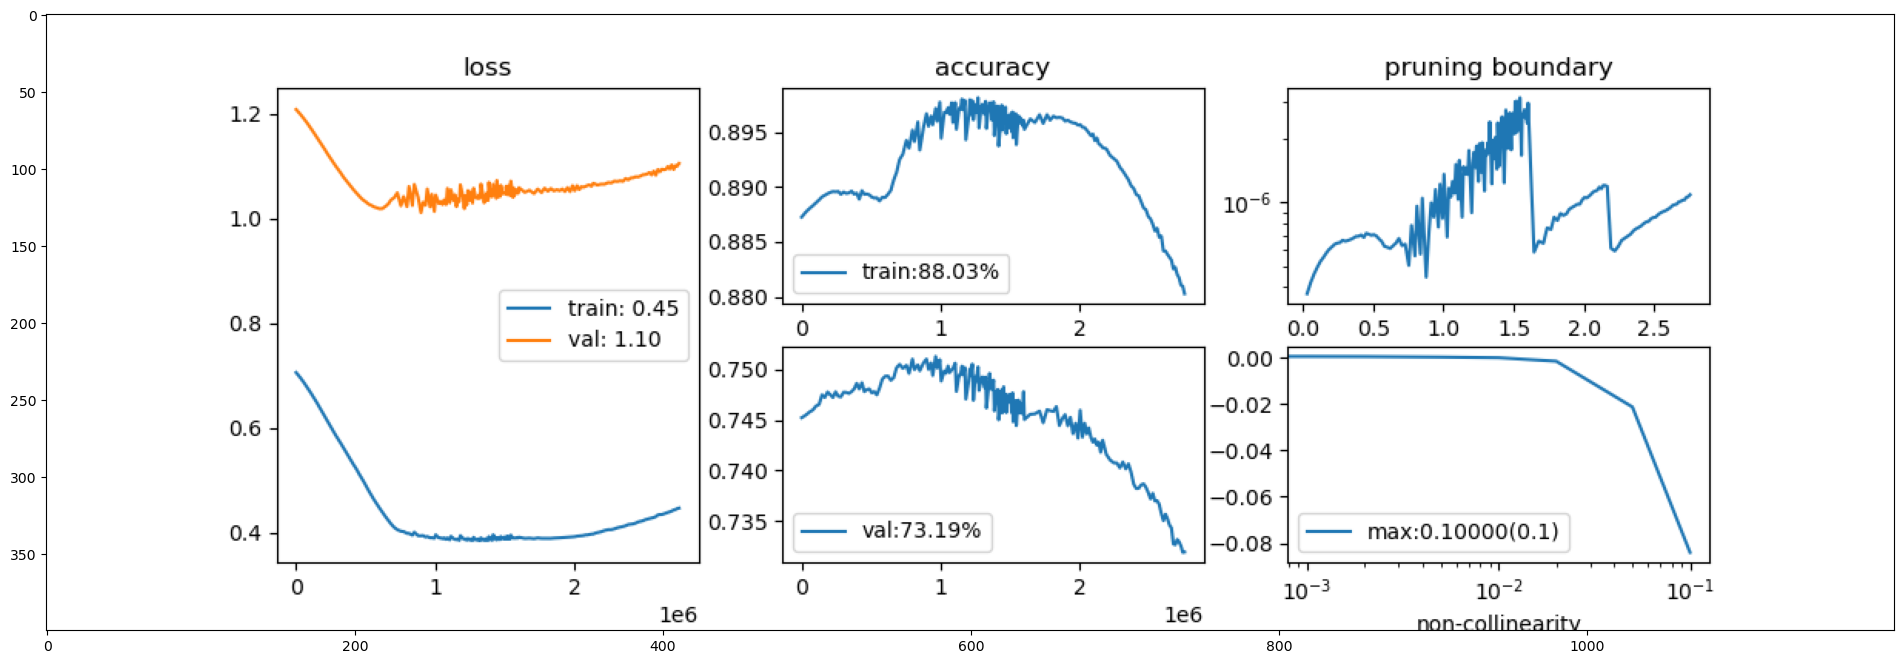

In [10]:
image = Image.open('sparsed/progress_step180.png')
image.load()
plt.figure(figsize=(24,8))
plt.imshow(image)
plt.show()


Напоминалка с процессом обучения для себя: Начало как и в прошлый раз - 118 щагов прореживания на 0.01 с адаптивным критерием 10-5, потом 28 шагов с критерием 20 пачками 2e-3, Потом ещё 34 с критерием 40. Разморозка не использовалась. Судя по графикам 40 - уже перебор и с подбором гиперпараметров стоит остановится на 30. Без разморозки, поэтому далеко не лучший результат. Позже выложу вариант с разморозкой.